# Classifying ECG data

This data set is publically available in www.timeseriesclassification.com and represents two types of electrocardiogram (ECG) readings: with cardiac event and without.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df=pd.read_csv("./data/ECG200_TRAIN.txt", header=None, sep='\s+')

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,-1.0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,...,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1.0,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,...,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1.0,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,...,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,-1.0,1.168874,2.075901,1.760140,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,...,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,1.0,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,...,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190


## Data exploration

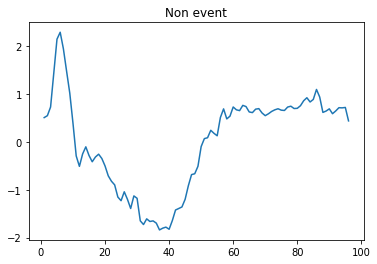

In [4]:
df.iloc[0,1:].plot(title="Non event")

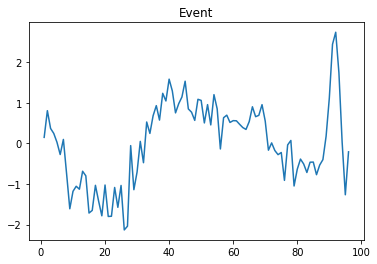

In [5]:
df.iloc[1,1:].plot(title="Event")

## Preprocessing

One big difference between these two pictures is that the ECG in the case of a cardiac event is very "spiky". It is often useful to smoothen out. Sometimes this is done by sophisticated methods, for instance, the Savitzky-Golay filter. 

We will do that by "integrating" those spectra:

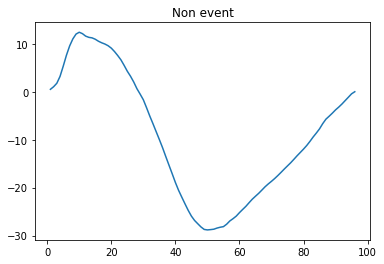

In [6]:
df.iloc[0,1:].cumsum().plot(title="Non event")

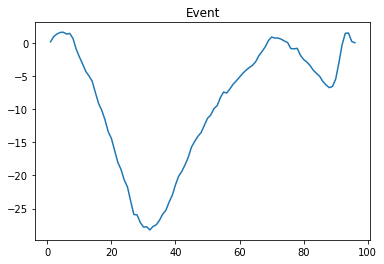

In [7]:
df.iloc[1,1:].cumsum().plot(title="Event")

## Creating a baseline model

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression

In [9]:
X_train = np.array([df.iloc[col,1:].cumsum().values for col in range(len(df))])
y_train = df.iloc[:,0]

In [10]:
X_train.shape

(100, 96)

Note that we have almost the same number of features as training examples! Perhaps we need to remove some of those.

In [11]:
sel=SelectKBest(k=10)
lr=LogisticRegression(random_state=42)
pipe=make_pipeline(sel, lr)

In [12]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001F7E8FE89D8>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [13]:
pipe.score(X_train, y_train)

0.86

## Finding the optimal number of features

We can tune the hyperparameter `k` from `SelectKBest` to determine the number of features.

In [14]:
lr=LogisticRegression()
Ks = [k for k in range(2,97)]
scores = []
for k in Ks:
    sel=SelectKBest(k=k)
    pipe=make_pipeline(sel, lr)
    pipe.fit(X_train,y_train)
    scores.append(pipe.score(X_train,y_train))
    

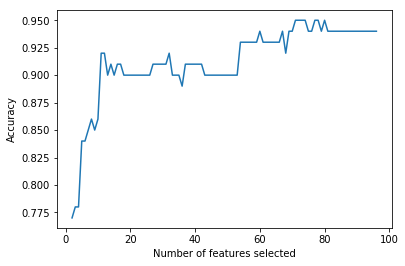

In [15]:
plt.plot(Ks, scores)
plt.xlabel("Number of features selected")
plt.ylabel("Accuracy")
plt.show()

We see that there is an increase in performance as the number of features increases. The spikes are due to the fact that we have very little data. 

This is taken on the training set, to be more precise we could use instead the cross validation error.

## Final model and feature importance

To understand better our features, let's plot the scores together with two samples of our ECG data.

In [16]:
sel=SelectKBest(k=60)
sel.fit(X_train,y_train)

SelectKBest(k=60, score_func=<function f_classif at 0x000001F7E8FE89D8>)

In [17]:
normalized_scores = (sel.scores_-sel.scores_.min())/(sel.scores_.max()-sel.scores_.min())

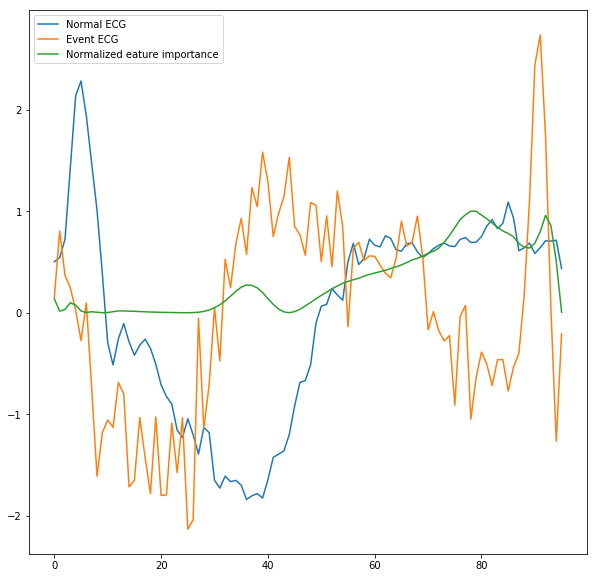

In [18]:
plt.figure(figsize=(10,10))
plt.plot(df.iloc[0,1:].values, label="Normal ECG")
plt.plot(df.iloc[1,1:].values, label="Event ECG")
plt.plot(normalized_scores, label="Normalized eature importance")
plt.legend()
plt.show()

This suggests that there is not a lot of information in the first 30 or so features, except for a peak at around 35. The most informative part of this signal is on the second half of the features.